# - 라이브러리 불러오기

In [1]:
import os
import gc
import numpy as np
import pandas as pd
import math
import random
from time import time
from tqdm import tqdm # 진행상태바를 표현하기 위한 라이브러리
from pathlib import Path

import torch
from torch import nn, cuda
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset

from torch.optim import Adam, SGD, Optimizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# 시드고정


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

#Class란?!

class 는 일종의 함수와 변수의 집합이다!!!!

class에서 사용되는 __init__은  파이썬에서 쓰이는 생성자이다. 객체가 생성될때 자동으로 호출되는 부분.(class로 부터 만들어지는 것을 객체라고 함)

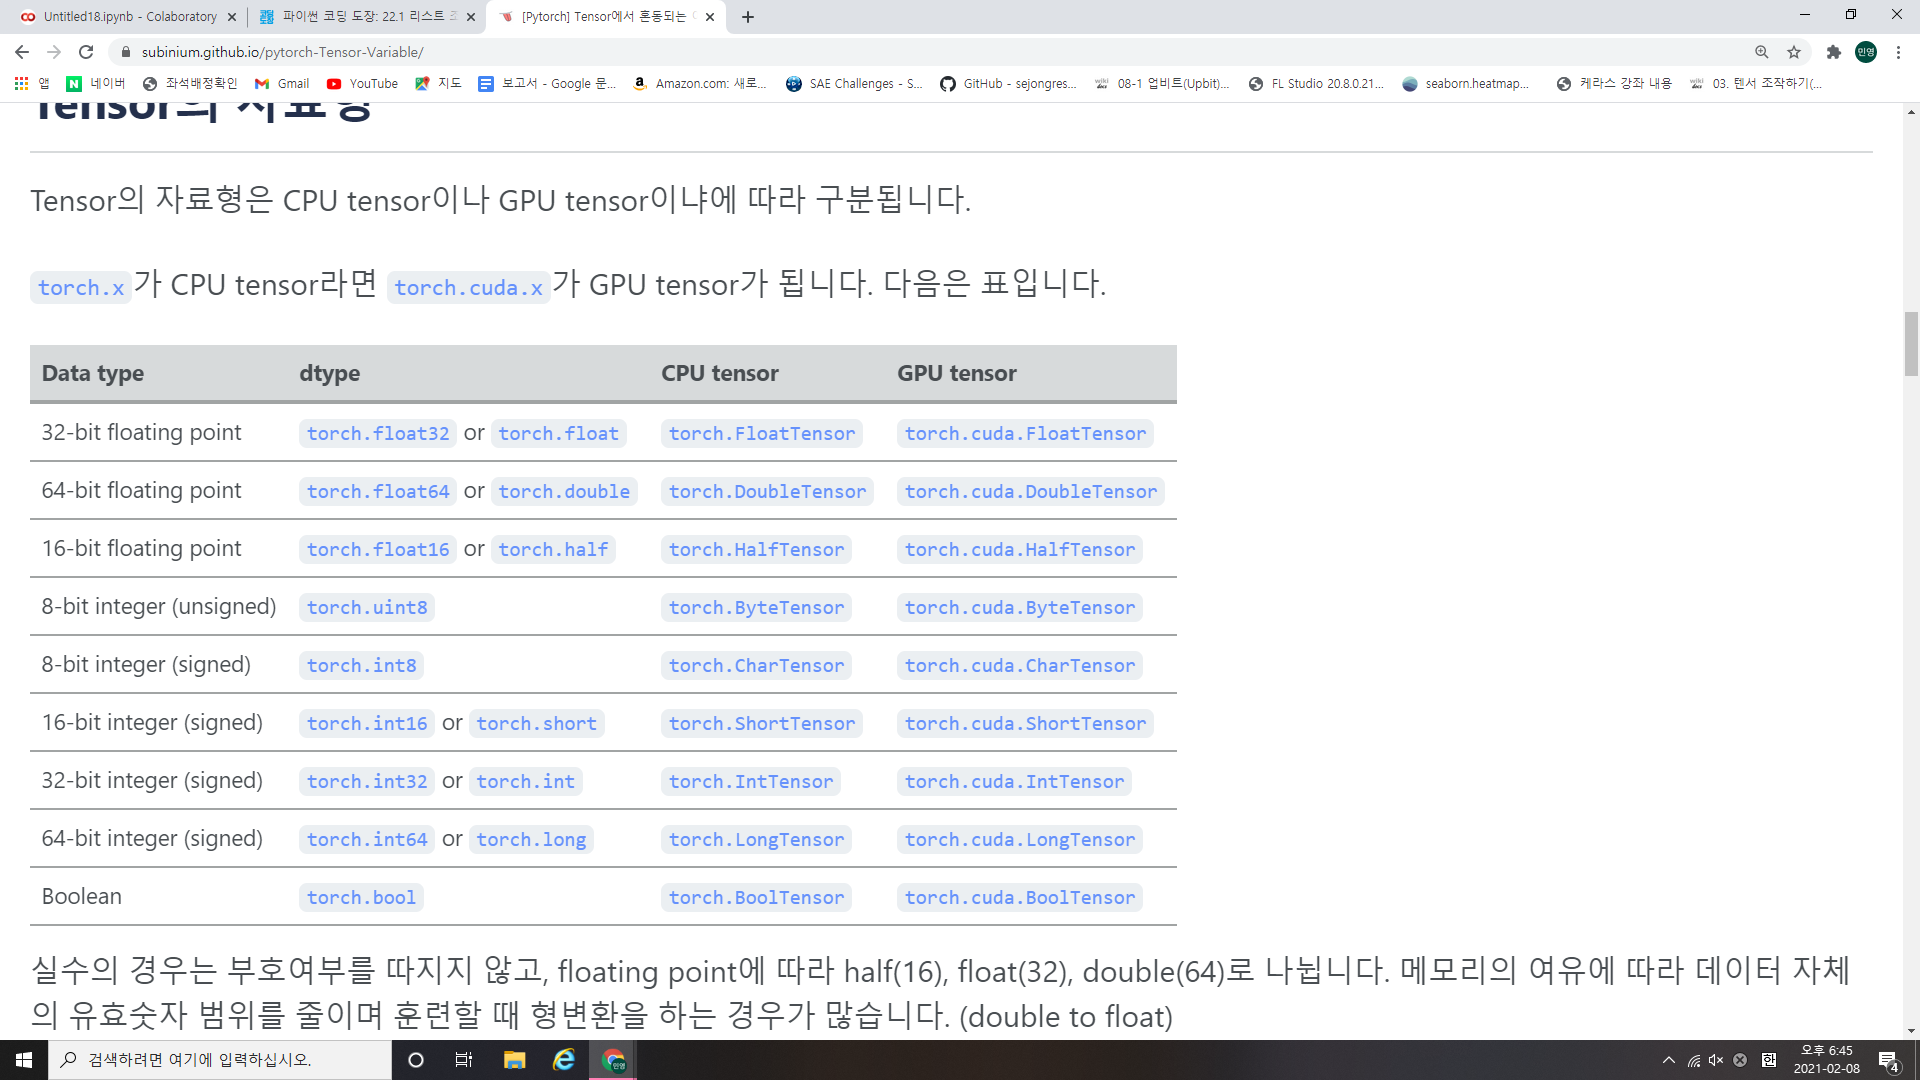

In [3]:
#Dataset을 받아 X_dataset에 tensor형태로 append한다.
class Semi_dataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.X_dataset = []
        self.Y_dataset = []
        for x in X:
            self.X_dataset.append(torch.FloatTensor(x)) #torch.FloatTensor는 cpu텐서 / torch.cuda.FloatTensor는 GPU텐서

# try와 except로 예외처리 사용 가능 / y의 values가 존재하면 텐서형태로 append 아니면 nolabel출력
        try:
            for y in Y.values:
                self.Y_dataset.append(torch.tensor(y))
        except:
            print("no label")
#길이 얻기            
    def __len__(self):
        return len(self.X)
# __getitem은 슬라이싱
    def __getitem__(self, index):
        data = self.X_dataset[index]
        try:
            target = self.Y_dataset[index]
            return data, target
        except:
            return data

#torch의 DataLoader를 이용하여 dataload ('https://tutorials.pytorch.kr/beginner/data_loading_tutorial.html', 'https://wingnim.tistory.com/33')
def build_dataloader(X, Y, batch_size, shuffle=False):
    
    dataset = Semi_dataset(X, Y)
    dataloader = DataLoader(
                            dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            num_workers=1
                            )
    return dataloader

In [4]:
def mean_absolute_error(y_true, y_pred,
                        sample_weight=None,
                        multioutput='uniform_average'):
    
    output_errors = np.average(np.abs(y_pred - y_true),
                               weights=sample_weight, axis=0)
    if isinstance(multioutput, str):
        if multioutput == 'raw_values':
            return output_errors
        elif multioutput == 'uniform_average':
            multioutput = None

    return np.average(output_errors, weights=multioutput)


In [5]:
class AdamW(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay)
        super(AdamW, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('AdamW does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

                if group['weight_decay'] != 0:
                    p.data.add_(-group['weight_decay'], p.data)

        return loss

#Layer 마다 Batch Normalization을 하는 이유는?!
배치 정규화의 장점은 다음과 같다.

1. 학습 속도를 빠르게 할 수 있다.

2. 가중치 초기화에 대한 민감도를 감소시킨다.

3. 모델의 일반화(Regularization)효과가 있다.

#why?

->입력 데이터를 정규화 하게 되면 상대적으로 더 큰 learning rate를 사용해도 괜찮기 때문이다. 각 축에 대해서 분산이 비슷하므로

(일반적으로 PCA나 화이트닝 보다는 정규화가 더 많이 사용된다. 간단하면서 좋은 성능을 뽑을 수 있기 때문에)

화이트닝(Whitening) : 평균이 0 이고 공분산이 단위행렬인 정규분포 형태의 데이터로 변환 하는 것.

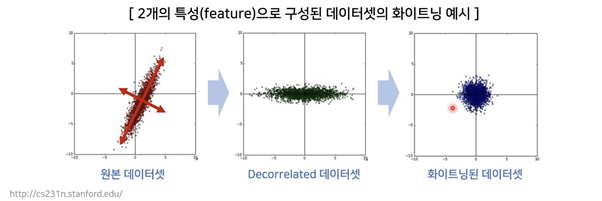


#Batch Normalization이 언급된 아이디아
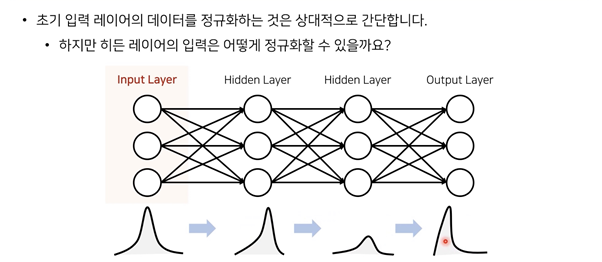


적은 개수의 파라미터를 추가함으로써 학습속도를 빠르게  향상시킬수 있음!
(보통의 순서는 weight upgrade -> BN -> activation 순으로 배치했을 때 좋은 성능을 낸다고 함)

BN을 사용하면 학습을 위한 하이퍼파라미터 선택에 좀더 자유롭고, 학습이 빠르게 수행됨!

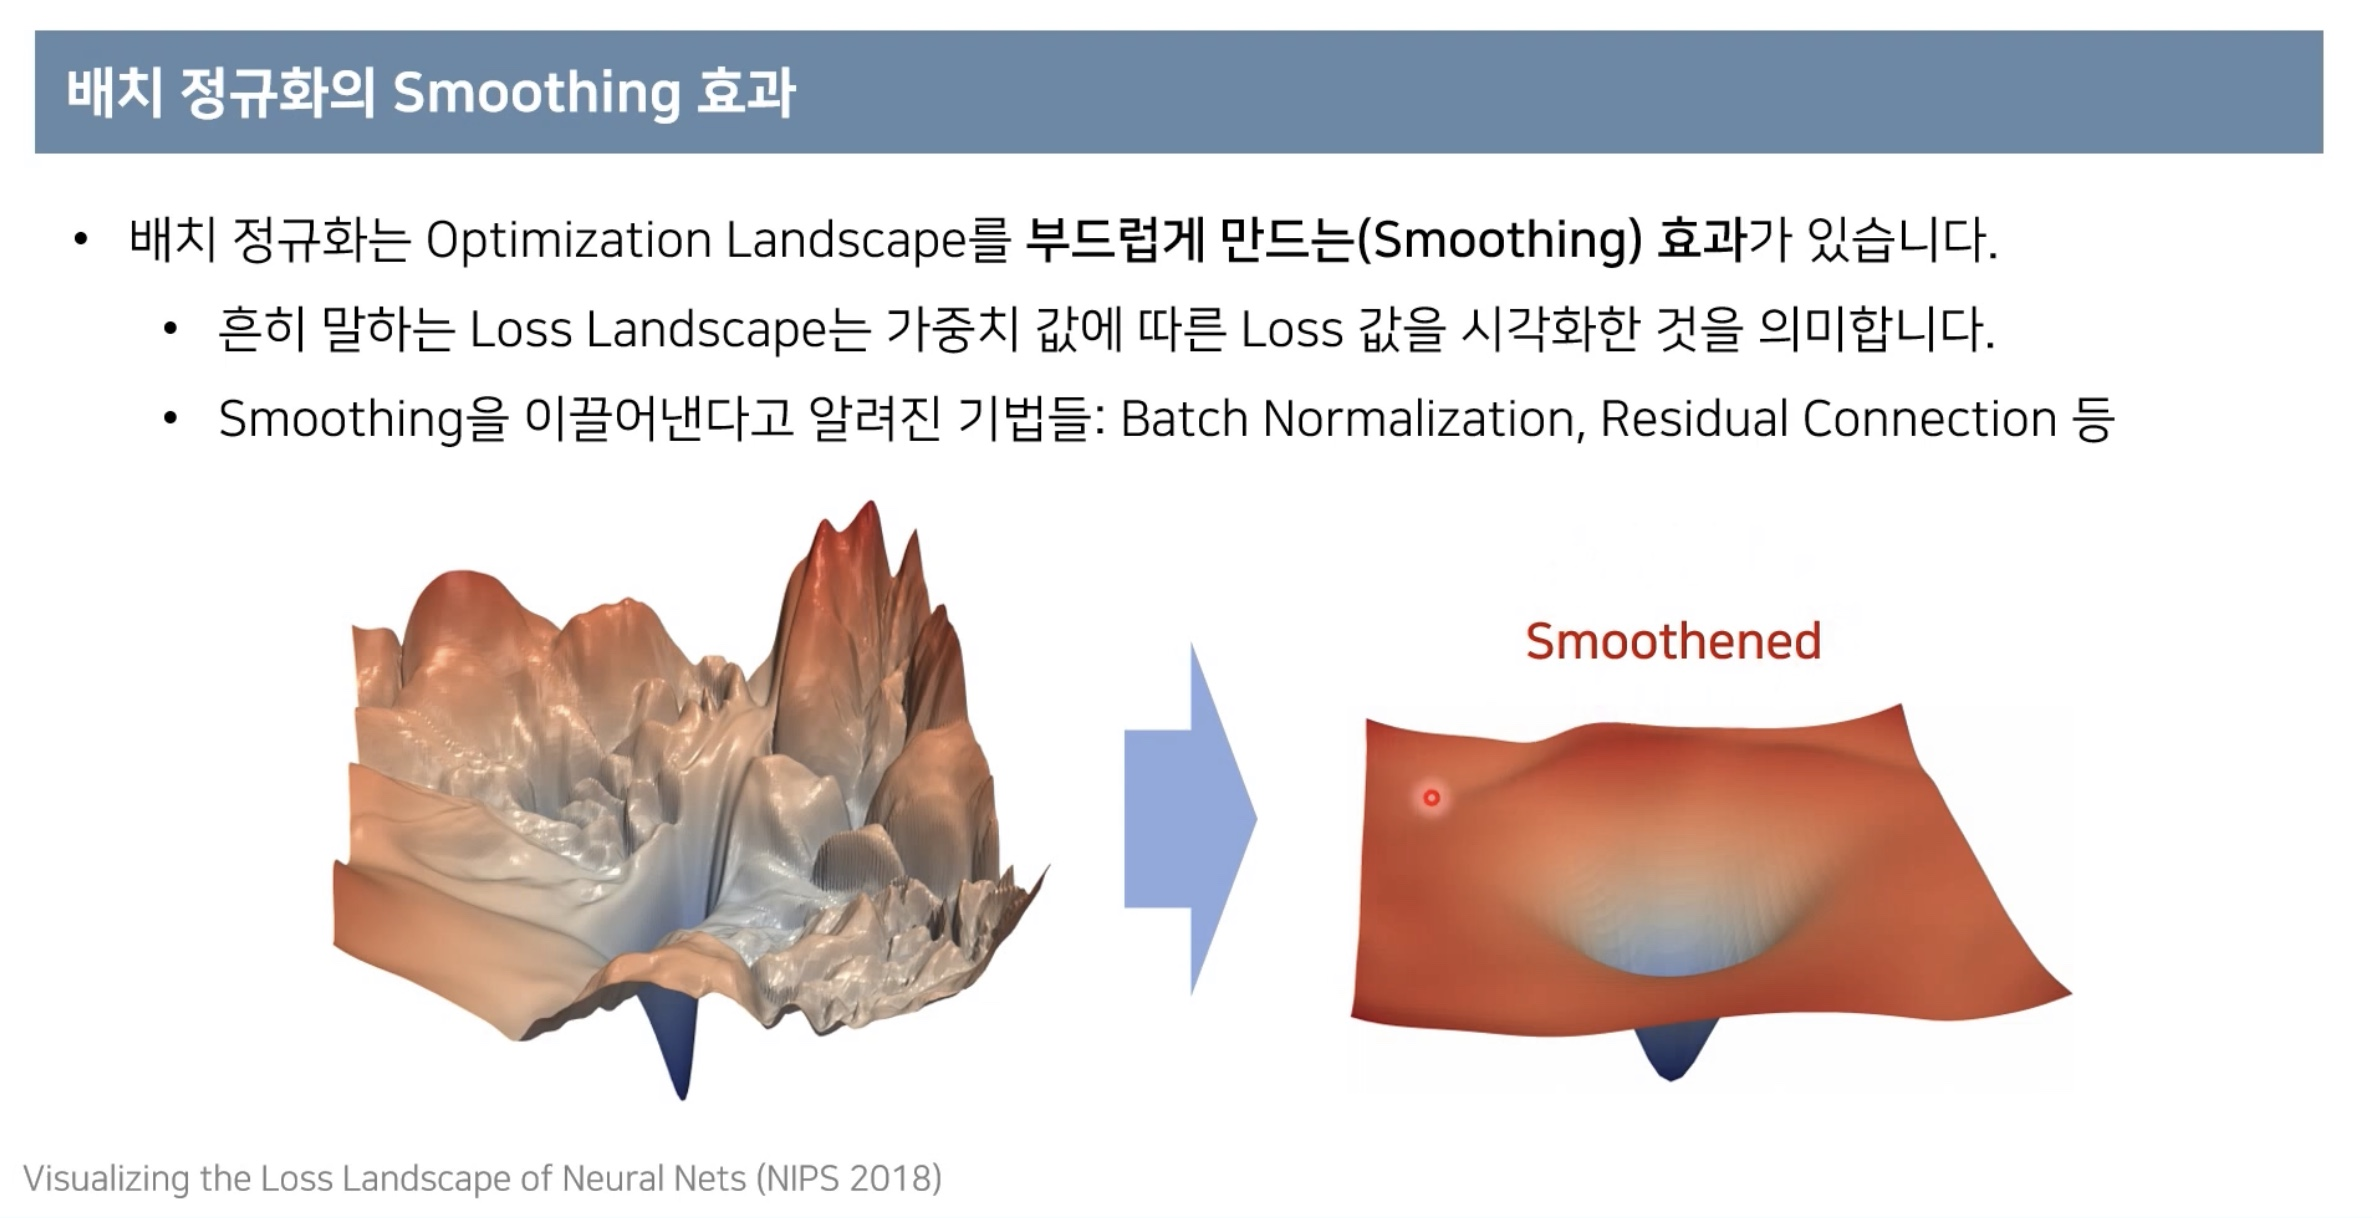


(https://youtu.be/58fuWVu5DVU)

In [6]:
class MLP_only_flatfeatures(nn.Module):
    def __init__(self, num_classes=1):
        super(MLP_only_flatfeatures, self).__init__()
        self.num_classes = num_classes         
        self.fc_layers = nn.Sequential(
            nn.Linear(226, 1000), #Layer1
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Linear(1000, 500),  #Layer2
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(500, 128),  #Layer3
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, self.num_classes)#Layer4
            )             
        self._initialize_weights()

    def forward(self, x):
        out = self.fc_layers(x)
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [7]:
def build_model(device, model_name='mlp', weight_path=None):

    if model_name == 'mlp':
        model = MLP_only_flatfeatures(4)
    
    return model


In [8]:
def validation(model, criterion, valid_loader, device):
    
    model.eval()
    valid_preds = np.zeros((len(valid_loader.dataset), 4))
    valid_targets = np.zeros((len(valid_loader.dataset), 4))
    val_loss = 0.
    
    with torch.no_grad():
        for i, (data, target) in enumerate(valid_loader):
            
            valid_targets[i * batch_size: (i+1) * batch_size] = target.float().numpy().copy()

            data = data.to(device)
            target = target.float().to(device)
                
            output = model(data)
            loss = criterion(output, target)
            
            valid_preds[i * batch_size: (i+1) * batch_size] = output.detach().cpu().numpy()
            
            val_loss += loss.item() / len(valid_loader)
    
    val_score = mean_absolute_error(valid_preds, valid_targets)

    return val_loss, val_score

In [9]:
seed = 42
seed_everything(seed)

In [10]:
if cuda.is_available:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [11]:
DATASET_PATH = '/content/drive/MyDrive/캐글스터디/반도체 박막두께분석'
train_df = pd.read_csv(os.path.join(DATASET_PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATASET_PATH, 'test.csv'))
submission_df = pd.read_csv(os.path.join(DATASET_PATH, 'sample_submission.csv'))

In [12]:
train_df

,layer_1,layer_2,layer_3,layer_4,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225
0,10,10,10,10,0.254551,0.258823,0.254659,0.252085,0.247678,0.253614,0.246511,0.259407,0.260862,0.242524,0.253870,0.245156,0.245548,0.255501,0.228948,0.228632,0.225802,0.249418,0.246910,0.248747,0.251088,0.244886,0.233906,0.242632,0.221792,0.236521,0.220555,0.243761,0.230202,0.226122,0.220671,0.235075,0.224560,0.226998,0.209499,0.226594,...,0.160126,0.164192,0.171406,0.162364,0.168591,0.166626,0.169696,0.196383,0.194145,0.190646,0.186797,0.191748,0.190886,0.208518,0.211220,0.229286,0.226265,0.226954,0.229023,0.237112,0.262421,0.262566,0.272062,0.292049,0.305353,0.292889,0.317479,0.316911,0.321371,0.355636,0.354750,0.369223,0.388184,0.408496,0.414564,0.429403,0.419225,0.443250,0.433414,0.465502
1,10,10,10,20,0.205062,0.225544,0.217758,0.202169,0.199633,0.207380,0.191318,0.195369,0.200536,0.197588,0.198726,0.191803,0.199625,0.206465,0.182836,0.193341,0.180459,0.196416,0.185398,0.188913,0.176011,0.173457,0.182249,0.176816,0.192716,0.185924,0.183816,0.186900,0.161040,0.173525,0.172948,0.182634,0.161153,0.158073,0.152335,0.148293,...,0.327076,0.331195,0.337722,0.340189,0.342748,0.351925,0.372989,0.389663,0.396216,0.384977,0.383701,0.403894,0.406382,0.429342,0.409908,0.439307,0.432569,0.439114,0.459541,0.454988,0.475268,0.478575,0.483466,0.496912,0.499542,0.522705,0.524767,0.533952,0.558729,0.572470,0.557203,0.573656,0.587998,0.612754,0.627825,0.633393,0.637706,0.625981,0.653231,0.637853
2,10,10,10,30,0.189196,0.165869,0.177655,0.156822,0.175094,0.177755,0.157582,0.158885,0.156911,0.166162,0.148831,0.144950,0.151362,0.145110,0.159201,0.139296,0.145313,0.156555,0.145363,0.150352,0.150542,0.142990,0.139572,0.145669,0.144514,0.126263,0.112832,0.117535,0.111473,0.117545,0.107058,0.119299,0.110768,0.124217,0.124496,0.110023,...,0.525450,0.532645,0.539097,0.527091,0.531925,0.530325,0.551716,0.556125,0.567470,0.549711,0.566789,0.574313,0.569873,0.574390,0.601672,0.584206,0.602981,0.598708,0.615189,0.637023,0.626458,0.645439,0.629203,0.640967,0.652762,0.660495,0.676498,0.674599,0.693535,0.699182,0.699864,0.708688,0.721982,0.713464,0.743030,0.741709,0.747743,0.746037,0.737356,0.750391
3,10,10,10,40,0.131003,0.120076,0.138975,0.117931,0.130566,0.131262,0.126962,0.134453,0.106717,0.127309,0.099958,0.112908,0.106853,0.108288,0.101393,0.094074,0.086854,0.099669,0.107276,0.091117,0.084525,0.078293,0.076476,0.078559,0.072960,0.075898,0.067963,0.066055,0.087904,0.065373,0.075469,0.080097,0.068895,0.058148,0.057882,0.063258,...,0.616934,0.638654,0.630914,0.647135,0.629796,0.644114,0.641825,0.645360,0.653030,0.656335,0.657734,0.678019,0.676713,0.681540,0.673333,0.686743,0.697500,0.702650,0.693750,0.711013,0.714411,0.701010,0.726972,0.719394,0.726329,0.730821,0.740062,0.747356,0.749405,0.766173,0.764786,0.763788,0.770017,0.787571,0.778866,0.776969,0.774712,0.801526,0.805305,0.784057
4,10,10,10,50,0.091033,0.086893,0.108125,0.080405,0.105917,0.077083,0.097895,0.086765,0.078676,0.075729,0.086023,0.070649,0.078957,0.072772,0.069867,0.080523,0.068273,0.074660,0.069852,0.047442,0.067855,0.049580,0.068737,0.041386,0.048697,0.040278,0.050234,0.059371,0.042581,0.037117,0.041503,0.055113,0.034001,0.035846,0.030385,0.048935,...,0.670888,0.692846,0.673025,0.704448,0.696657,0.697524,0.692513,0.714224,0.696880,0.716361,0.723607,0.720018,0.715039,0.705079,0.720913,0.723440,0.719858,0.729948,0.731360,0.728861,0.740501,0.738362,0.749341,0.738456,0.768791,0.770292,0.766630,0.779970,0.787695,0.766521,0.786677,0.802271,0.806557,0.799614,0.789333,0.804087,0.787763,0.794948,0.819105,0.801781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [13]:
X_train, X_val, y_train, y_val = train_test_split(train_df.iloc[:, 4:], train_df.iloc[:, :4], test_size=0.02, random_state=42, shuffle=True)

In [14]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225
167818,0.010169,0.037965,0.034387,0.069965,0.091254,0.135072,0.173867,0.197703,0.233960,0.294586,0.314938,0.349287,0.381015,0.425086,0.441031,0.477178,0.509650,0.522018,0.547970,0.545746,0.564996,0.580719,0.599928,0.619428,0.622449,0.630053,0.624941,0.629629,0.633377,0.656957,0.643482,0.647948,0.629984,0.639711,0.638918,0.628580,0.630121,0.610551,0.604117,0.579780,...,0.497945,0.489634,0.484236,0.461327,0.441341,0.421791,0.409638,0.392109,0.358762,0.339732,0.324405,0.299820,0.278923,0.284506,0.289126,0.306838,0.294079,0.337351,0.349931,0.383963,0.404836,0.428847,0.469461,0.493199,0.526221,0.528829,0.572495,0.587465,0.612631,0.617826,0.643790,0.646198,0.652745,0.664206,0.677891,0.685123,0.667179,0.663637,0.654387,0.636387
240636,0.059087,0.055900,0.024706,0.015139,0.025241,0.045104,0.043192,0.090119,0.110599,0.147447,0.194527,0.231646,0.286951,0.310028,0.359614,0.406268,0.439352,0.448039,0.494994,0.523533,0.556728,0.560509,0.586590,0.611343,0.614336,0.640730,0.634505,0.653678,0.666132,0.677104,0.677466,0.674175,0.681497,0.685771,0.682277,0.686574,0.676249,0.672698,0.673997,0.690527,...,0.733781,0.725477,0.723140,0.722823,0.698710,0.695004,0.665169,0.634582,0.629008,0.595304,0.553853,0.538317,0.476864,0.455450,0.383172,0.330342,0.269898,0.219488,0.178646,0.130355,0.118218,0.104668,0.114995,0.165028,0.195477,0.274364,0.332820,0.413563,0.473334,0.526741,0.557839,0.621407,0.648533,0.668688,0.719110,0.728059,0.757923,0.743062,0.778685,0.772118
492499,0.383551,0.376671,0.347641,0.328240,0.300152,0.271747,0.231316,0.199233,0.182980,0.160750,0.143018,0.131030,0.115396,0.118992,0.102862,0.099783,0.124881,0.120297,0.146974,0.149212,0.168140,0.170447,0.208169,0.231427,0.237579,0.242174,0.259562,0.284329,0.276677,0.312083,0.296691,0.309497,0.325375,0.326054,0.316601,0.319858,0.312774,0.320650,0.305267,0.287989,...,0.714591,0.714744,0.717404,0.713955,0.684026,0.674093,0.657917,0.654503,0.620904,0.590269,0.575123,0.553489,0.521384,0.480431,0.427839,0.370917,0.340052,0.294290,0.235382,0.193148,0.187111,0.155593,0.155816,0.188840,0.211689,0.255106,0.309646,0.366911,0.409334,0.442337,0.504066,0.537281,0.566657,0.596235,0.628360,0.653791,0.656451,0.685270,0.682583,0.682462
651187,0.206453,0.224922,0.277035,0.290350,0.322493,0.370552,0.399606,0.417227,0.450786,0.446455,0.465225,0.493029,0.524646,0.518916,0.521785,0.531543,0.546283,0.563687,0.548589,0.559538,0.574573,0.551264,0.556827,0.544341,0.552706,0.527127,0.523945,0.522889,0.508719,0.485948,0.457519,0.427927,0.409230,0.379614,0.339132,0.304830,0.258416,0.215231,0.190962,0.145035,...,0.648041,0.668047,0.703406,0.715139,0.734064,0.767200,0.759836,0.792210,0.785991,0.791617,0.809891,0.791381,0.801896,0.809101,0.813718,0.814546,0.795800,0.803983,0.785824,0.801827,0.795790,0.762187,0.758767,0.746268,0.705771,0.692998,0.659562,0.628982,0.576247,0.534711,0.484353,0.421519,0.351462,0.275030,0.208617,0.131234,0.118675,0.110298,0.112141,0.177240
420291,0.026436,0.041922,0.051626,0.059555,0.087257,0.127595,0.150360,0.168954,0.166482,0.197849,0.178830,0.181058,0.176850,0.177625,0.169745,0.145703,0.136100,0.126866,0.104189,0.070367,0.055683,0.032295,0.035468,0.019842,0.035090,0.043843,0.043253,0.089172,0.127752,0.148960,0.184609,0.234102,0.257794,0.295207,0.318507,0.334463,0.346739,0.348999,0.355212,0.369789,...,0.584398,0.618771,0.615472,0.625352,0.630388,0.641757,0.629352,0.608698,0.592815,0.572561,0.525159,0.454521,0.384556,0.329260,0.222220,0.141888,0.078413,0.067031,0.088253,0.199722,0.315259,0.435064,0.537263,0.617703,0.711871,0.755183,0.796551,0.814305,0.834629,0.853782,0.865319,0.869271,0.883084,0.905023,0.906260,0.880400,0.874045,0.877220,0.879097,0.864947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [15]:
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [16]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225
0,0.010169,0.037965,0.034387,0.069965,0.091254,0.135072,0.173867,0.197703,0.233960,0.294586,0.314938,0.349287,0.381015,0.425086,0.441031,0.477178,0.509650,0.522018,0.547970,0.545746,0.564996,0.580719,0.599928,0.619428,0.622449,0.630053,0.624941,0.629629,0.633377,0.656957,0.643482,0.647948,0.629984,0.639711,0.638918,0.628580,0.630121,0.610551,0.604117,0.579780,...,0.497945,0.489634,0.484236,0.461327,0.441341,0.421791,0.409638,0.392109,0.358762,0.339732,0.324405,0.299820,0.278923,0.284506,0.289126,0.306838,0.294079,0.337351,0.349931,0.383963,0.404836,0.428847,0.469461,0.493199,0.526221,0.528829,0.572495,0.587465,0.612631,0.617826,0.643790,0.646198,0.652745,0.664206,0.677891,0.685123,0.667179,0.663637,0.654387,0.636387
1,0.059087,0.055900,0.024706,0.015139,0.025241,0.045104,0.043192,0.090119,0.110599,0.147447,0.194527,0.231646,0.286951,0.310028,0.359614,0.406268,0.439352,0.448039,0.494994,0.523533,0.556728,0.560509,0.586590,0.611343,0.614336,0.640730,0.634505,0.653678,0.666132,0.677104,0.677466,0.674175,0.681497,0.685771,0.682277,0.686574,0.676249,0.672698,0.673997,0.690527,...,0.733781,0.725477,0.723140,0.722823,0.698710,0.695004,0.665169,0.634582,0.629008,0.595304,0.553853,0.538317,0.476864,0.455450,0.383172,0.330342,0.269898,0.219488,0.178646,0.130355,0.118218,0.104668,0.114995,0.165028,0.195477,0.274364,0.332820,0.413563,0.473334,0.526741,0.557839,0.621407,0.648533,0.668688,0.719110,0.728059,0.757923,0.743062,0.778685,0.772118
2,0.383551,0.376671,0.347641,0.328240,0.300152,0.271747,0.231316,0.199233,0.182980,0.160750,0.143018,0.131030,0.115396,0.118992,0.102862,0.099783,0.124881,0.120297,0.146974,0.149212,0.168140,0.170447,0.208169,0.231427,0.237579,0.242174,0.259562,0.284329,0.276677,0.312083,0.296691,0.309497,0.325375,0.326054,0.316601,0.319858,0.312774,0.320650,0.305267,0.287989,...,0.714591,0.714744,0.717404,0.713955,0.684026,0.674093,0.657917,0.654503,0.620904,0.590269,0.575123,0.553489,0.521384,0.480431,0.427839,0.370917,0.340052,0.294290,0.235382,0.193148,0.187111,0.155593,0.155816,0.188840,0.211689,0.255106,0.309646,0.366911,0.409334,0.442337,0.504066,0.537281,0.566657,0.596235,0.628360,0.653791,0.656451,0.685270,0.682583,0.682462
3,0.206453,0.224922,0.277035,0.290350,0.322493,0.370552,0.399606,0.417227,0.450786,0.446455,0.465225,0.493029,0.524646,0.518916,0.521785,0.531543,0.546283,0.563687,0.548589,0.559538,0.574573,0.551264,0.556827,0.544341,0.552706,0.527127,0.523945,0.522889,0.508719,0.485948,0.457519,0.427927,0.409230,0.379614,0.339132,0.304830,0.258416,0.215231,0.190962,0.145035,...,0.648041,0.668047,0.703406,0.715139,0.734064,0.767200,0.759836,0.792210,0.785991,0.791617,0.809891,0.791381,0.801896,0.809101,0.813718,0.814546,0.795800,0.803983,0.785824,0.801827,0.795790,0.762187,0.758767,0.746268,0.705771,0.692998,0.659562,0.628982,0.576247,0.534711,0.484353,0.421519,0.351462,0.275030,0.208617,0.131234,0.118675,0.110298,0.112141,0.177240
4,0.026436,0.041922,0.051626,0.059555,0.087257,0.127595,0.150360,0.168954,0.166482,0.197849,0.178830,0.181058,0.176850,0.177625,0.169745,0.145703,0.136100,0.126866,0.104189,0.070367,0.055683,0.032295,0.035468,0.019842,0.035090,0.043843,0.043253,0.089172,0.127752,0.148960,0.184609,0.234102,0.257794,0.295207,0.318507,0.334463,0.346739,0.348999,0.355212,0.369789,...,0.584398,0.618771,0.615472,0.625352,0.630388,0.641757,0.629352,0.608698,0.592815,0.572561,0.525159,0.454521,0.384556,0.329260,0.222220,0.141888,0.078413,0.067031,0.088253,0.199722,0.315259,0.435064,0.537263,0.617703,0.711871,0.755183,0.796551,0.814305,0.834629,0.853782,0.865319,0.869271,0.883084,0.905023,0.906260,0.880400,0.874045,0.877220,0.879097,0.864947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [18]:
batch_size = 2048
train_loader = build_dataloader(X_train, y_train, batch_size, shuffle=True)
valid_loader = build_dataloader(X_val, y_val, batch_size, shuffle=False)

In [19]:
train_loader

In [20]:
test_df.iloc[:, 1:] = scaler.transform(test_df.iloc[:, 1:])

In [21]:
# output path
output_dir = Path('./', 'output')
output_dir.mkdir(exist_ok=True, parents=True)

In [22]:
num_epochs = 150
criterion = nn.L1Loss()

In [ ]:
best_epoch_list = []
best_valid_score_list = []

# build model
model = build_model(device, model_name='mlp')
model.to(device)

lr = 0.05
optimizer = AdamW(model.parameters(), lr)

start_time = time()

best_epoch = 0
best_train_loss = 1000
best_valid_score = 1000

for epoch in range(num_epochs):

    model.train()
    optimizer.zero_grad()
    train_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):

        if device:
            data = data.to(device)
            target = target.float().to(device)
        else:
            target = target.float()

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item() / len(train_loader)

    val_loss, val_score = validation(model, criterion, valid_loader, device)

    elapsed = time() - start_time

    lr = [_['lr'] for _ in optimizer.param_groups]

    if epoch % 1 == 0:
        print('Epoch {} / {}  train Loss: {:.4f}  val_loss: {:.4f}  val_score: {:.4f}  lr: {:.5f}  elapsed: {:.0f}m {:.0f}s' \
              .format(epoch,  num_epochs - 1, train_loss, val_loss, val_score, lr[0], elapsed // 60, elapsed % 60))
        
    model_path = output_dir / 'best_model.pt'

    if val_score < best_valid_score:
        best_valid_score = val_score
        best_epoch = epoch
        torch.save(model.state_dict(), model_path)


    best_epoch_list.append(best_epoch)
    best_valid_score_list.append(best_valid_score)


Epoch 0 / 149  train Loss: 45.9776  val_loss: 23.2003  val_score: 23.2028  lr: 0.05000  elapsed: 0m 8s
Epoch 1 / 149  train Loss: 22.1202  val_loss: 16.4751  val_score: 16.4794  lr: 0.05000  elapsed: 0m 16s
Epoch 2 / 149  train Loss: 18.4888  val_loss: 13.7659  val_score: 13.7689  lr: 0.05000  elapsed: 0m 24s
Epoch 3 / 149  train Loss: 16.7698  val_loss: 13.0509  val_score: 13.0523  lr: 0.05000  elapsed: 0m 31s
Epoch 4 / 149  train Loss: 15.7586  val_loss: 11.4367  val_score: 11.4403  lr: 0.05000  elapsed: 0m 39s
Epoch 5 / 149  train Loss: 15.0550  val_loss: 10.4472  val_score: 10.4512  lr: 0.05000  elapsed: 0m 47s
Epoch 6 / 149  train Loss: 14.5207  val_loss: 9.9245  val_score: 9.9275  lr: 0.05000  elapsed: 0m 55s
Epoch 7 / 149  train Loss: 14.1752  val_loss: 9.9937  val_score: 9.9966  lr: 0.05000  elapsed: 1m 3s
Epoch 8 / 149  train Loss: 13.7803  val_loss: 9.1263  val_score: 9.1282  lr: 0.05000  elapsed: 1m 11s
Epoch 9 / 149  train Loss: 13.5054  val_loss: 8.9768  val_score: 8.9776 

In [ ]:
for epoch, score in zip(best_epoch_list, best_valid_score_list):
    print(epoch, score)

In [ ]:
np.mean(best_valid_score_list)

In [ ]:
batch_size = 2048
test_loader = build_dataloader(test_df.iloc[:, 1:].values, Y=None, batch_size=batch_size, shuffle=False)

In [ ]:
model = build_model(device, model_name='mlp')
model.to(device)

model.eval()

model.load_state_dict(torch.load(model_path))

test_preds = np.zeros((len(test_loader.dataset), 4))

with torch.no_grad():
    for batch_idx, data in enumerate(test_loader):

        if device:
            data = data.to(device)
        outputs = model(data)
        test_preds[batch_idx * batch_size:(batch_idx+1) * batch_size] = outputs.detach().cpu().numpy()

In [ ]:
submission = pd.DataFrame({'id': submission_df['id'],
                           'layer_1':test_preds.transpose()[0],
                           'layer_2':test_preds.transpose()[1],
                           'layer_3':test_preds.transpose()[2],
                           'layer_4':test_preds.transpose()[3]})
submission.to_csv('submission.csv', index=False)

In [ ]:
submission.head()